In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import shift
from scipy.optimize import curve_fit

def sfilter(coeff, lambda_max=None, f_lambda=None, D=None, Dpix=None, z=None):
    global nx, pupil, fx, fy
    k = 1000*coeff
    lambda_max_new = int(lambda_max*coeff)
    lambdas = np.linspace(0, lambda_max_new, k) * pow(10, -9) # [м]

    tail = np.zeros((len(lambdas) - len(f_lambda)))
    f_lambda_new = np.append(f_lambda, tail)
    res_fft = pow((np.imag(np.fft.fft(f_lambda_new/lambdas))), 2)

    delta_lambdas = (lambda_max_new / len(lambdas)) * pow(10, -9) # период дискретизации, шаг по частоте [м]
    omega_lambdas_scale = 1 / (delta_lambdas) # максимальное значение по частоте, [м^-1]

    delta = D/pupil.shape[0] # шаг субапертуры, период дискретизации (то, насколько одно значение отстает от следующего) [м]
    f_scale = 1/(delta*nx) # шаг по частоте, [м^-1]

    f_abs = np.sqrt(pow(fx, 2) + pow(fy, 2))

    omega = 0.5 * z * pow(f_abs, 2) # аргумент, шаг по частоте, [м^-1]
    omega = np.ravel(omega)
    omega_new = np.interp(omega, np.linspace(0, omega_lambdas_scale, k), res_fft)
    omega_new = np.resize(omega_new, (nx, nx))
    
    return omega_new

def c_jk(data, Dpix):
    nx = 2 * Dpix + 1 # ширина окна для автокорреляции зрачка (должно быть минимум в 2 раза больше, чем ширина зрачка)
    I0c = (data != 0) * int(1)
    I0c = np.pad(I0c, ((nx - I0c.shape[0])//2, (nx - I0c.shape[1])//2), 'constant', constant_values=(0))
    res = np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fft2(I0c)*np.fft.fft2(I0c).conjugate())))
    res /= np.max(res)
    return res, nx


def aperture_func(fx, fy, delta): 
    res = np.abs(np.sinc(delta*fx)*np.sinc(delta*fy))**2
    return res
    
def abs_f(fx, fy):
    res = pow(np.sqrt(fx**2+fy**2), -11./3.)
    res[np.isnan(res)] = 0
    return res

def gamma_poly(X, Y, Vx, Vy, Cn2, z):
    global cjk, f_scale, nx, f_11_3, A_f, pupil, resp_f, sec_per_frame, latency
    const = 9.69*pow(10, -3)*16*pow(np.pi, 2) # константа перед интегралом 
    
    t = sec_per_frame * latency
    Lx = Vx*t
    Ly = Vy*t
    Xpix = Lx/delta
    Ypix = Ly/delta
        
    S = sfilter(100, lambda_max=resp_f[0][-1], f_lambda=resp_f[1], D=D, Dpix=pupil.shape[0], z=z)    
    
    res = f_11_3 * S * A_f
    res[np.isnan(res)] = 0
    res = np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fftshift(res))))
    
    res = Cn2 * const * res * pow(f_scale, 2) * nx * nx    
    res = shift(res, (-Ypix, Xpix), order=5)
    res = res * cjk
    return res

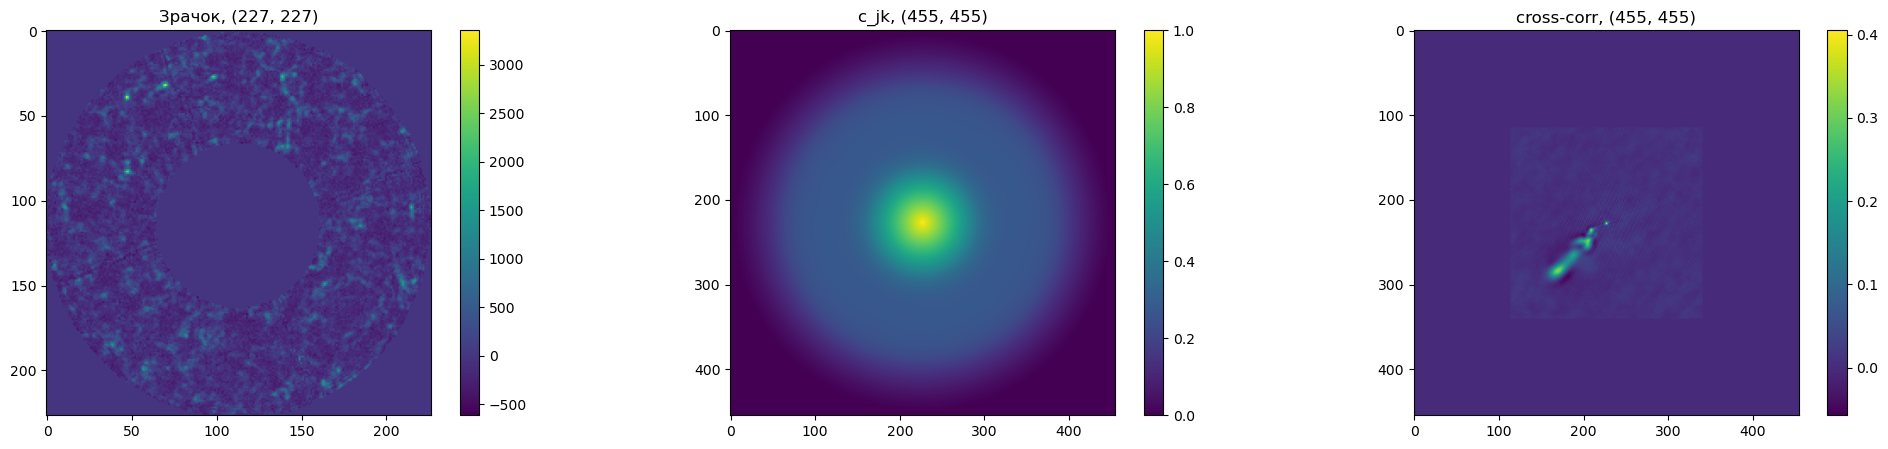

In [2]:
np.seterr(all="ignore")
resp_f = np.loadtxt('C:/astro/resp_f.gz')

D = 2.5
latency = 4
sec_per_frame = 0.01
z_0 = 2000
Cn2 = 1*pow(10, -13)

pupil = np.loadtxt('C:/astro/data.gz')
data = np.loadtxt('C:/astro/data_corr.gz')
a = int(2*pupil.shape[0]+2 - data.shape[0])//2
b = int(2*pupil.shape[1]+2 - data.shape[1])//2
data = np.pad(data, ((a, a), (b, b)), 'constant', constant_values=(0))

cjk, nx = c_jk(pupil, pupil.shape[0])
f_scale = pupil.shape[0]/(D*nx)
delta = D/pupil.shape[0] 

xx, yy = np.meshgrid(np.linspace(-nx//2, nx//2-1, nx), np.linspace(-nx//2, nx//2-1, nx))
fx = f_scale * xx 
fy = f_scale * yy

f_11_3 = abs_f(fx, fy)
A_f = aperture_func(fx, fy, delta)




fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))

fig.colorbar(ax.imshow(pupil), ax = ax)
ax.grid(False)
ax.set_title(f'Зрачок, {pupil.shape}')

fig.colorbar(ax2.imshow(cjk), ax=ax2)
ax2.grid(False)
ax2.set_title(f'c_jk, {cjk.shape}')

fig.colorbar(ax3.imshow(data), ax=ax3)
ax3.grid(False)
ax3.set_title(f'cross-corr, {data.shape}')

print(' ')

In [5]:
x = np.linspace(-data.shape[1]//2, data.shape[1]//2-1, data.shape[1])
y = np.linspace(-data.shape[0]//2, data.shape[0]//2-1, data.shape[0])
X, Y = np.meshgrid(x, y)
xdata = np.vstack((X.ravel(), Y.ravel()))
ydata = data.ravel()

def speckle_fit(xcoord, ycoord, Cn2_ex, z_dist):
    global xdata, ydata, sec_per_frame, latency, delta, z_0
    if z_dist == z_0:
        tmp = 2000
    if z_dist != 2000:
        tmp = np.inf

    params = [(xcoord, ycoord, Cn2_ex, z_dist)]
    p0 = [p for prms in params for p in prms]


    def _g(M, *args):
        x, y = M
        arr = np.zeros(x.shape)
        for i in range(len(args)//4):
            arr += gamma_poly(x, y, *args[i*4:i*4+4]).ravel()       
        return arr

    st=time.perf_counter()

    popt, pcov = curve_fit(_g, xdata, ydata, p0, bounds=[[xcoord-10, ycoord-10, 0, 2000],
                                                         [xcoord+10, ycoord+10, 1*pow(10, -11), tmp+1]]) # bounds?

    print('Time:', time.perf_counter()-st)
    print('Fitted parametrs:', popt)
    
    fit = np.zeros(X.shape)
    for i in range(len(popt)//4):
        fit += gamma_poly(X, Y, *popt[i*4:i*4+4])

    
    t = sec_per_frame * latency
    Xpix = int(popt[0]*t/delta)
    Ypix = int(popt[1]*t/delta)
    
    return fit, Xpix, Ypix, popt[2]
    

def multi_speckle_fit(params=None):
    global data, a, b
    myParams = [p for prms in params for p in prms]
    
    res = np.zeros(data.shape)
    cr = data.shape[0]//2 # центр изображения
    X = []
    Y = []
    Cn2 = []
    
    for i in range(len(myParams)//4):
        print(f'\nSpeckle N.{i+1}:', *myParams[i*4:i*4+4])
        fit, xcoord, ycoord, Cn2_fitted = speckle_fit(*myParams[i*4:i*4+4])
        res += fit
        X.append(xcoord)
        Y.append(ycoord)
        Cn2.append(Cn2_fitted)
        print('-max fitted value:', np.max(fit))
        print('-max initial value:', np.max(data[cr-ycoord-4:cr-ycoord+4, cr+xcoord-4:cr+xcoord+4]))
    
    print(' ')
    print('RMS:', np.sqrt(np.mean((data - res)**2)))
    lambda_=500*pow(10, -9) # нм
    k = 2*np.pi/lambda_
    r0 = pow(0.423*pow(k, 2)*(np.sum(Cn2)), -3/5)
    print('sum Cn2:', np.sum(Cn2))
    print('r0, sm:', 100*r0)
    print('seeing, arcsec:', 0.98 *206265 * lambda_/r0)
    return res, X, Y


Speckle N.1: 0 0 2.887430620123135e-12 2000
Time: 4.1811064999999985
Fitted parametrs: [-1.92089568e-02 -2.62730545e-01  4.16834813e-12  2.00000000e+03]
-max fitted value: 0.5767493595378277
-max initial value: 0.40507408099072595

Speckle N.2: -7.5 -7.5 1e-12 12000
Time: 6.410001600000001
Fitted parametrs: [-6.52174907e+00 -6.52576844e+00  6.37991331e-13  1.78619739e+04]
-max fitted value: 0.3982554722564813
-max initial value: 0.31984441413604164

Speckle N.3: -15 -15 1e-12 16000
Time: 8.51989549999999
Fitted parametrs: [-1.57981105e+01 -1.55242816e+01  6.21888982e-13  3.90918235e+04]
-max fitted value: 0.3474888827765406
-max initial value: 0.32909854877439776
 
RMS: 0.00968555061050879
sum Cn2: 5.428228443977345e-12
r0, sm: 2.9130576058078432
seeing, arcsec: 3.469545188481486



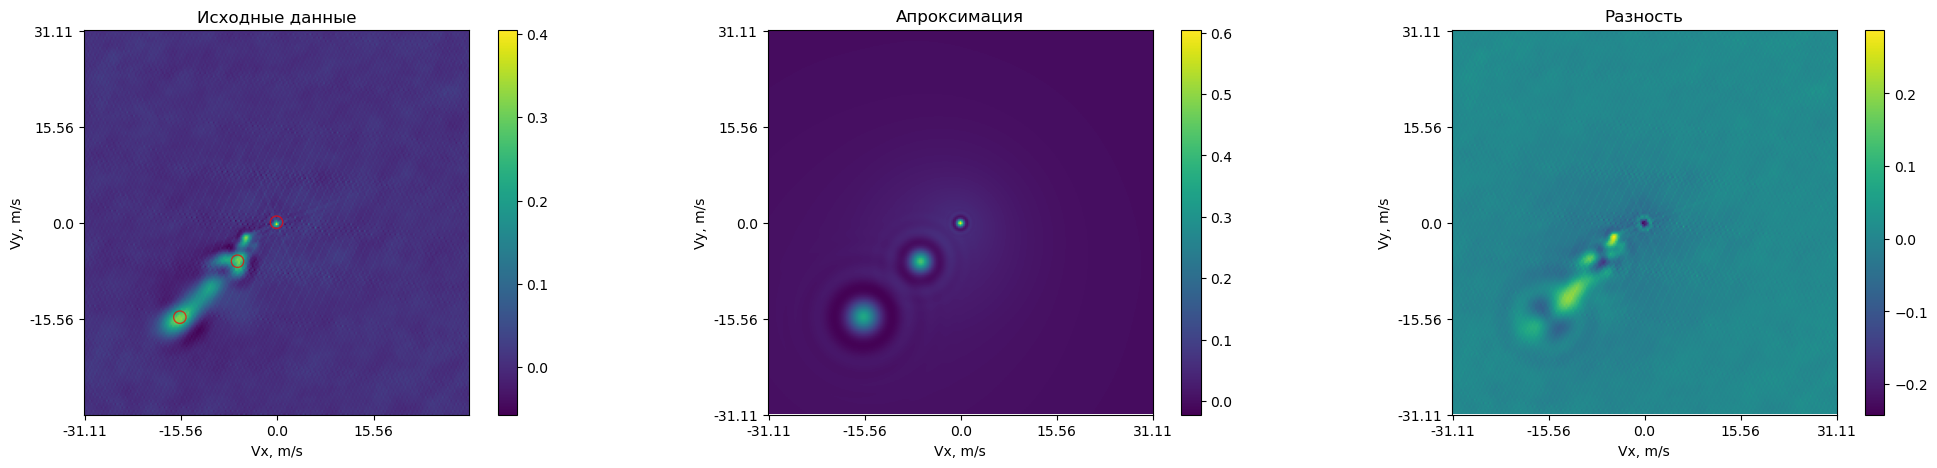

In [6]:
# myParams = [(Vx, Vy, Cn2, z)]
myParams = [( 0,   0,   2.887430620123135e-12, z_0),
            (-7.5, -7.5, 1*pow(10, -12), 12000),
            (-15, -15,   1*pow(10, -12), 16000)]

fit, speckle_x, speckle_y = multi_speckle_fit(params=myParams)




# ------------ Отрисовка ---------------------------
fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))

cr = data[a:data.shape[0]-a, b:data.shape[1]-b].shape[0]//2 # центр изображения
v = (D / pupil.shape[0]) / (latency * sec_per_frame)
x = np.round(v*np.linspace(-pupil.shape[0]//2+1, pupil.shape[0]//2, 5), 2)
y = np.round(v*np.linspace(-pupil.shape[0]//2+1, pupil.shape[0]//2, 5), 2)
y = np.flipud(y)

fig.colorbar(ax.imshow(data[a:data.shape[0]-a, b:data.shape[1]-b]), ax=ax)
ax.set_title('Исходные данные')
ax.set_xticks(np.linspace(0, data[a:data.shape[0]-a, b:data.shape[1]-b].shape[1], 5))
ax.set_yticks(np.linspace(0, data[a:data.shape[0]-a, b:data.shape[1]-b].shape[0], 5))
ax.set_xticklabels(x)
ax.set_yticklabels(y)
ax.set_ylabel('Vy, m/s')
ax.set_xlabel('Vx, m/s')


for i in range(len(speckle_x)):
    ax.scatter(cr+speckle_x[i], cr-speckle_y[i], alpha=0.7, s=80, facecolors='none', edgecolors='r')
    
fig.colorbar(ax2.imshow(fit[a:fit.shape[0]-a, b:fit.shape[1]-b]), ax=ax2)
ax2.set_title('Апроксимация')
ax2.set_xticks(np.linspace(0, fit[a:fit.shape[0]-a, b:fit.shape[1]-b].shape[1], 5))
ax2.set_yticks(np.linspace(0, fit[a:fit.shape[0]-a, b:fit.shape[1]-b].shape[0], 5))
ax2.set_xticklabels(x)
ax2.set_yticklabels(y)
ax2.set_ylabel('Vy, m/s')
ax2.set_xlabel('Vx, m/s')

fig.colorbar(ax3.imshow((data-fit)[a:data.shape[0]-a, b:data.shape[1]-b]), ax=ax3)
ax3.set_title('Разность')
ax3.set_xticks(np.linspace(0, (data-fit)[a:data.shape[0]-a, b:data.shape[1]-b].shape[1], 5))
ax3.set_yticks(np.linspace(0, (data-fit)[a:data.shape[0]-a, b:data.shape[1]-b].shape[0], 5))
ax3.set_xticklabels(x)
ax3.set_yticklabels(y)
ax3.set_ylabel('Vy, m/s')
ax3.set_xlabel('Vx, m/s')
print('')
# fig.savefig('C:/astro/approx.png', bbox_inches='tight')

In [14]:
lambda_=500*pow(10, -9) # нм
k = 2*np.pi/lambda_
# r0 = pow(0.423*pow(k, 2)*(4.16834813e-12*2.00000000e+03+6.37991331e-13*1.78619739e+04+
#                                          6.21888982e-13*3.90918235e+04), -3/5)

r0 = pow(0.423*pow(k, 2)*(5.428228443977345e-12), -3/5)

seeing = 0.98 * lambda_/r0
# seeing*206265
print('beta', seeing*206265)
print('r0', r0*100)
print('')
print(4.16834813e-12+6.37991331e-13+6.21888982e-13)
print(5.428228443977345e-12)

beta 3.4695451884814865
r0 2.9130576058078432

5.4282284429999995e-12
5.428228443977345e-12
